In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import itertools

Load the data
The first series contains data on milk production. The series contains a pronounced seasonal trend and there is an obvious upward trend over time.
The second series contains data on the import of products in Australia.

In [2]:
data_milk = pd.read_csv('monthly-milk-production-pounds-p.csv')[:-1:]
data_imports = pd.read_csv('monthly-australian-imports-from-.csv')[:-1:]

data_milk_drop = data_milk.drop(['Month'], 1)
data_imports_drop = data_imports.drop(['Month'], 1)

Reshaping data and building a graph

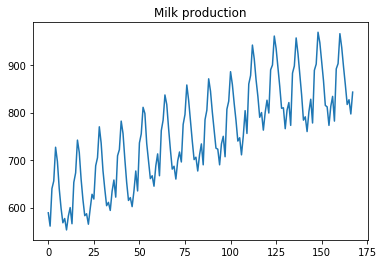

In [4]:
data_milk_drop.values.reshape(-1,1)
plt.plot(data_milk_drop)
plt.title('Milk production')
plt.show()

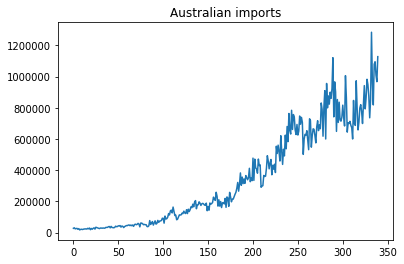

In [5]:
data_imports_drop.values.reshape(-1,1)
plt.plot(data_imports_drop)
plt.title('Australian imports')
plt.show()

Data Preprocessing

In [6]:
window_size = 30
timeseries = np.array(data_milk_drop)
scaler_milk = MinMaxScaler() # For normalizing dataset
timeseries_scaler = scaler_milk.fit_transform(timeseries)

X_1 = np.atleast_3d(np.array([timeseries_scaler[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
X_30 = np.atleast_3d(np.array([timeseries_scaler[start:start + window_size] for start in range(0, timeseries_scaler.shape[0]
                                                                                                  - window_size+1, 15)]))

X_batch_1 = np.array(X_1[:-1]).reshape(-1, window_size, 1)
y_batch_1 = np.array(X_1[1:]).reshape(-1, window_size, 1)
X_test_data_1 = np.array(X_1[:]).reshape(-1, window_size, 1)
y_test_data_1 = np.array(data_milk_drop[30::])

X_batch_30 = np.array(X_30[:-1]).reshape(-1, window_size, 1)
y_batch_30 = np.array(X_30[1:]).reshape(-1, window_size, 1)
X_test_data_30 = np.array(X_30[:]).reshape(-1, window_size, 1)
y_test_data_30 = np.array(data_milk_drop[30::])

In [7]:
timeseries_imports = np.array(data_imports_drop)
scaler_imports = MinMaxScaler() # For normalizing dataset

timeseries_imports_scaler = scaler_imports.fit_transform(timeseries_imports)


X_imports_1 = np.atleast_3d(np.array([timeseries_imports_scaler[start:start + window_size] for start in range(0, timeseries_imports.shape[0] - window_size)]))
X_imports_30 = np.atleast_3d(np.array([timeseries_imports_scaler[start:start + window_size] for start in range(0, timeseries_imports_scaler.shape[0]
                                                                                                  - window_size+1, 15)]))

X_imports_batch_1 = np.array(X_imports_1[:-1]).reshape(-1, window_size, 1)
y_imports_batch_1 = np.array(X_imports_1[1:]).reshape(-1, window_size, 1)
X_imports_test_data_1 = np.array(X_imports_1[:]).reshape(-1, window_size, 1)
y_imports_test_data_1 = np.array(data_imports_drop[30::])

X_imports_batch_30 = np.array(X_imports_30[:-1]).reshape(-1, window_size, 1)
y_imports_batch_30 = np.array(X_imports_30[1:]).reshape(-1, window_size, 1)
X_imports_test_data_30 = np.array(X_imports_30[:]).reshape(-1, window_size, 1)
y_imports_test_data_30 = np.array(data_imports_drop[30:])

# Convolutional neural networks


In [8]:
tf.reset_default_graph()
learning_rate = 0.001

neural_net_model is function applying 2 hidden layer feed forward neural net.
Weights and biases are abberviated as W_1,W_2 and b_1, b_2 
These are variables with will be updated during training.

In [9]:
def neural_net_model(X_data):
    W_1 = tf.Variable(tf.random_uniform([1,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.tensordot(tf.cast(X_data, tf.float32), W_1, [[1], [0]]), b_1)
    layer_1 = tf.nn.relu(layer_1)

    # layer 1 multiplying and adding bias then activation function
    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.tensordot(tf.cast(layer_1, tf.float32), W_2, [[1], [0]]), b_2)
    layer_2 = tf.nn.relu(layer_2)
    # layer 2 multiplying and adding bias then activation function
    
    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.tensordot(tf.cast(layer_2, tf.float32), W_O, [[1], [0]]), b_O)
    # O/p layer multiplying and adding bias then activation function
    return output

x_input_cnn = tf.placeholder(tf.float32, [window_size, 1])
y_input_cnn = tf.placeholder(tf.float32, [window_size, 1])
output = neural_net_model(x_input_cnn)
loss = tf.reduce_max(tf.square(output-y_input_cnn))
train = tf.train.GradientDescentOptimizer(learning_rate= learning_rate).minimize(loss)

In [10]:
def session_cnn(epoches, X_input, y_input, X_test):
    loss_cnn = []
    y_pred_cnn = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        for i in range(epoches):
            for j in range(X_input.shape[0]):
                sess.run([loss,train],feed_dict= {x_input_cnn:X_input[j], y_input_cnn:y_input[j]})
                loss_cnn.append(sess.run(loss, feed_dict={x_input_cnn:X_input[j],y_input_cnn:y_input[j]}))
            if i % 100 == 0:
                print('Epoch :',i,'loss :',loss_cnn[i])
        for k in range(X_test.shape[0]):
            y_pred_cnn.append(sess.run(output, feed_dict={x_input_cnn:X_test[k]}))
    return y_pred_cnn

At the output of the neural network there will be a tensor, where the last or the last 15 values ​​are predicted. The following procedure is to combine only the predicted values ​​for all batches.

In [11]:
def data_transform(data, scaler, shift):
    y = []
    shift = shift*(-1)
    y = np.array(data)
    y = y[:, shift:]
    y = y.reshape(-1,1)
    y = scaler.inverse_transform(y)
    return y

Epoch : 0 loss : 33.30706
Epoch : 100 loss : 0.64042103
Epoch : 200 loss : 0.29636425
Epoch : 300 loss : 0.14680402
Epoch : 400 loss : 0.13993828


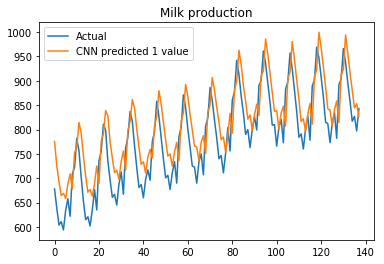

In [13]:
y_milk_cnn_1 = session_cnn(500, X_batch_1, y_batch_1, X_test_data_1)
y_milk_cnn_predict_1 = data_transform(y_milk_cnn_1,scaler_milk, 1)

plt.plot(pd.Series(np.ravel(y_test_data_1[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_milk_cnn_predict_1[0:])), label= "CNN predicted 1 value")
plt.legend(loc = "upper left")
plt.title('Milk production')
plt.show()

Epoch : 0 loss : 22.694668
Epoch : 100 loss : 0.46858463
Epoch : 200 loss : 0.43438813
Epoch : 300 loss : 0.3014422
Epoch : 400 loss : 0.2038754
Epoch : 500 loss : 0.22957604
Epoch : 600 loss : 0.2013593
Epoch : 700 loss : 0.1476272
Epoch : 800 loss : 0.13697045
Epoch : 900 loss : 0.18563065
Epoch : 1000 loss : 0.16936792
Epoch : 1100 loss : 0.11151712
Epoch : 1200 loss : 0.10571131
Epoch : 1300 loss : 0.092387944
Epoch : 1400 loss : 0.16674688


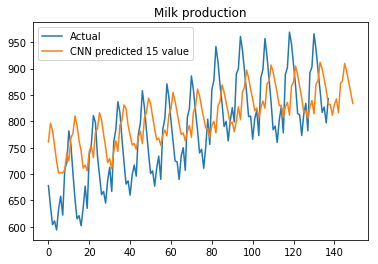

In [14]:
y_milk_cnn_30 = session_cnn(1500, X_batch_30, y_batch_30, X_test_data_30)
y_milk_cnn_predict_30 = data_transform(y_milk_cnn_30,scaler_milk, 15)

plt.plot(pd.Series(np.ravel(y_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_milk_cnn_predict_30[0:])), label= "CNN predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Milk production')
plt.show()

Epoch : 0 loss : 0.03863239
Epoch : 100 loss : 0.019125191
Epoch : 200 loss : 0.57329625
Epoch : 300 loss : 0.73092645
Epoch : 400 loss : 0.049565893


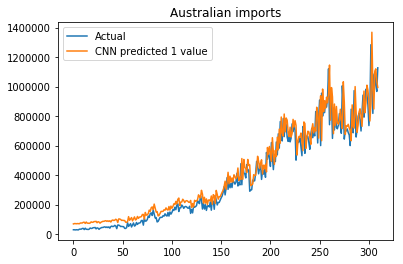

In [15]:
y_imports_cnn_1 = session_cnn(500, X_imports_batch_1, y_imports_batch_1, X_imports_test_data_1)
y_imports_cnn_predict_1 = data_transform(y_imports_cnn_1,scaler_imports, 1)

plt.plot(pd.Series(np.ravel(y_imports_test_data_1[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_cnn_predict_1[0:])), label= "CNN predicted 1 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()

Epoch : 0 loss : 0.022353105
Epoch : 100 loss : 0.016139729
Epoch : 200 loss : 0.006882901
Epoch : 300 loss : 0.00081153406
Epoch : 400 loss : 0.0012946671
Epoch : 500 loss : 0.005505468
Epoch : 600 loss : 0.010846964
Epoch : 700 loss : 0.017039811
Epoch : 800 loss : 0.022534128
Epoch : 900 loss : 0.027201403
Epoch : 1000 loss : 0.031154199
Epoch : 1100 loss : 0.03425367
Epoch : 1200 loss : 0.036603387
Epoch : 1300 loss : 0.038933665
Epoch : 1400 loss : 0.03952624


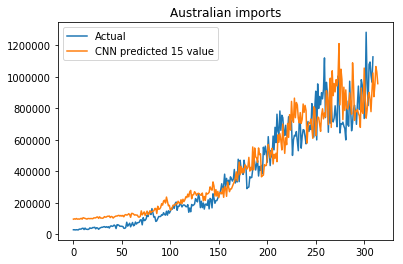

In [16]:
y_imports_cnn_30 = session_cnn(1500, X_imports_batch_30, y_imports_batch_30, X_imports_test_data_30)
y_imports_cnn_predict_30 = data_transform(y_imports_cnn_30,scaler_imports, 15)

plt.plot(pd.Series(np.ravel(y_imports_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_cnn_predict_30[0:])), label= "CNN predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()

# Basic recurrent neural networks

In [17]:
tf.reset_default_graph()
inputs = 1
hidden = 100
output = 1
learning_rate = 0.001
epoches = 1000

In [18]:
X_input_rnn = tf.placeholder(tf.float32, [None, window_size, inputs])
y_input_rnn = tf.placeholder(tf.float32, [None, window_size, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden, activation = tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X_input_rnn, dtype = tf.float32)

stacked_rnn_output = tf.reshape(rnn_output,[-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs=tf.reshape(stacked_outputs,[-1, window_size, output])

loss = tf.reduce_sum(tf.square(outputs -y_input_rnn))
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [19]:
def session_rnn(epoches, X_input, y_input, X_test):
    with tf.Session() as sess:
        init.run()
        for ep in range(epoches):
            sess.run(training_op, feed_dict = {X_input_rnn: X_input, y_input_rnn: y_input})
            if ep % 100 == 0:
                mse = loss.eval(feed_dict={X_input_rnn: X_input, y_input_rnn: y_input})
                print(ep, "\tMSE", mse)
        y_pred_rnn = sess.run(outputs, feed_dict = {X_input_rnn: X_test})
    return y_pred_rnn

0 	MSE 1716.0099
100 	MSE 51.613934
200 	MSE 22.26208
300 	MSE 11.684524
400 	MSE 9.416459
500 	MSE 8.125152
600 	MSE 7.5437784
700 	MSE 7.190525
800 	MSE 6.979392
900 	MSE 6.7222576


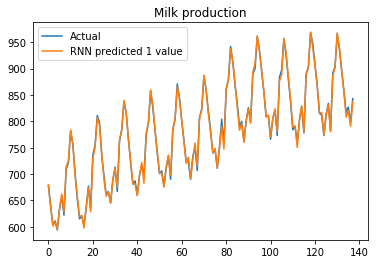

In [20]:
y_milk_rnn_1 = session_rnn(1000, X_batch_1, y_batch_1, X_test_data_1)
y_milk_rnn_predict_1 = data_transform(y_milk_rnn_1,scaler_milk, 1)

plt.plot(pd.Series(np.ravel(y_test_data_1[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_milk_rnn_predict_1[0:])), label= "RNN predicted 1 value")
plt.legend(loc = "upper left")
plt.title('Milk production')
plt.show()

0 	MSE 63.634377
100 	MSE 3.1649847
200 	MSE 1.5013788
300 	MSE 1.1797312
400 	MSE 0.86983436
500 	MSE 0.756505
600 	MSE 0.6770799
700 	MSE 0.7037219
800 	MSE 0.5909208
900 	MSE 0.61103594
1000 	MSE 0.5415414
1100 	MSE 0.5245926
1200 	MSE 0.509453
1300 	MSE 0.48998782
1400 	MSE 0.47304246
1500 	MSE 0.46272424
1600 	MSE 0.43631488
1700 	MSE 0.4216505
1800 	MSE 0.3991931
1900 	MSE 0.37961546


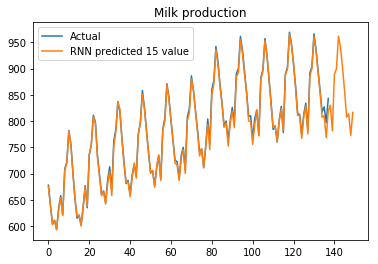

In [21]:
y_milk_rnn_30 = session_rnn(2000, X_batch_30, y_batch_30, X_test_data_30)
y_milk_rnn_predict_30 = data_transform(y_milk_rnn_30,scaler_milk, 15)

plt.plot(pd.Series(np.ravel(y_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_milk_rnn_predict_30[0:])), label= "RNN predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Milk production')
plt.show()

0 	MSE 610.27167
100 	MSE 25.152979
200 	MSE 19.031334
300 	MSE 13.207586
400 	MSE 8.806976
500 	MSE 6.7207003
600 	MSE 5.803094
700 	MSE 5.330531
800 	MSE 4.942915
900 	MSE 4.72478


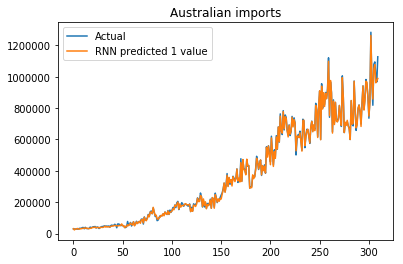

In [22]:
y_imports_rnn_1 = session_rnn(1000, X_imports_batch_1, y_imports_batch_1, X_imports_test_data_1)
y_imports_rnn_predict_1 = data_transform(y_imports_rnn_1,scaler_imports, 1)

plt.plot(pd.Series(np.ravel(y_imports_test_data_1[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_rnn_predict_1[0:])), label= "RNN predicted 1 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()

0 	MSE 73.375885
100 	MSE 3.0202038
200 	MSE 2.1319373
300 	MSE 1.8447022
400 	MSE 1.2205231
500 	MSE 1.0674117
600 	MSE 1.0094664
700 	MSE 1.0214188
800 	MSE 0.8683039
900 	MSE 0.77814716
1000 	MSE 0.7328627
1100 	MSE 0.65509707
1200 	MSE 0.66866153
1300 	MSE 0.5959656
1400 	MSE 0.5518987
1500 	MSE 0.54775256
1600 	MSE 0.500635
1700 	MSE 0.42389974
1800 	MSE 0.47244644
1900 	MSE 0.38474917


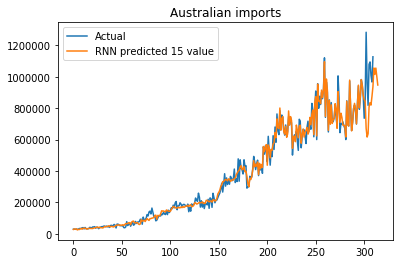

In [23]:
y_imports_rnn_30 = session_rnn(2000, X_imports_batch_30, y_imports_batch_30, X_imports_test_data_30)
y_imports_rnn_predict_30 = data_transform(y_imports_rnn_30,scaler_imports, 15)

plt.plot(pd.Series(np.ravel(y_imports_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_rnn_predict_30[0:])), label= "RNN predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()

# Long short-term memory network

In [24]:
tf.reset_default_graph()
inputs = 1
output = 1
learning_rate = 0.001
epoches = 1000

https://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html

In [25]:
X_input_lstm = tf.placeholder(tf.float32, [None, window_size, inputs])
y_input_lstm = tf.placeholder(tf.float32, [None, window_size, output])

layers = [tf.contrib.rnn.BasicLSTMCell(num_units = window_size) for k in range(10)]
cell = tf.contrib.rnn.OutputProjectionWrapper(
      tf.contrib.rnn.MultiRNNCell(layers), output_size = output)

outputs, states = tf.nn.dynamic_rnn(cell, X_input_lstm, dtype=tf.float32)
loss = tf.reduce_mean(tf.square(outputs - y_input_lstm))
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
training_op = optimizer.minimize(loss)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [26]:
init = tf.global_variables_initializer()
def session_lstm(epoches, X_input, y_input, X_test):
    with tf.Session() as sess:
        init.run()
        for ep in range(epoches):
            sess.run(training_op, feed_dict = {X_input_lstm: X_input, 
                                               y_input_lstm: y_input})
            if ep % 100 == 0:
                mse = loss.eval(feed_dict={X_input_lstm: X_input, y_input_lstm: y_input})
                print(ep, "\tMSE", mse)
        y_pred_lstm = sess.run(outputs, feed_dict = {X_input_lstm: X_test})
    return y_pred_lstm

0 	MSE 0.27938703
100 	MSE 0.046526216
200 	MSE 0.025742024
300 	MSE 0.023163326
400 	MSE 0.020609843
500 	MSE 0.019004036
600 	MSE 0.018081168
700 	MSE 0.017268319
800 	MSE 0.016078267
900 	MSE 0.014749579


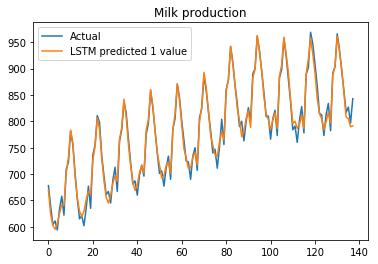

In [27]:
y_milk_lstm_1 = session_lstm(1000, X_batch_1, y_batch_1, X_test_data_1)
y_milk_lstm_predict_1 = data_transform(y_milk_lstm_1,scaler_milk, 1)

plt.plot(pd.Series(np.ravel(y_test_data_1[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_milk_lstm_predict_1[0:])), label= "LSTM predicted 1 value")
plt.legend(loc = "upper left")
plt.title('Milk production')
plt.show()

0 	MSE 0.30569986
100 	MSE 0.04666715
200 	MSE 0.02772833
300 	MSE 0.021909855
400 	MSE 0.01934974
500 	MSE 0.017504463
600 	MSE 0.016170349
700 	MSE 0.015415531
800 	MSE 0.013203289
900 	MSE 0.010139483
1000 	MSE 0.008238022
1100 	MSE 0.0073042302
1200 	MSE 0.0067925653
1300 	MSE 0.006272664
1400 	MSE 0.005940138
1500 	MSE 0.005491583
1600 	MSE 0.004891218
1700 	MSE 0.00419017
1800 	MSE 0.0037909707
1900 	MSE 0.003245758


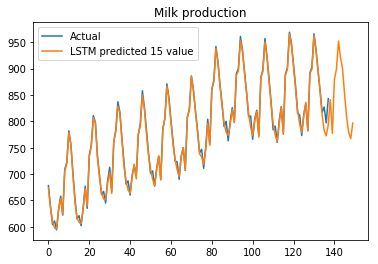

In [28]:
y_milk_lstm_30 = session_lstm(2000, X_batch_30, y_batch_30, X_test_data_30)
y_milk_lstm_predict_30 = data_transform(y_milk_lstm_30,scaler_milk, 15)

plt.plot(pd.Series(np.ravel(y_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_milk_lstm_predict_30[0:])), label= "LSTM predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Milk production')
plt.show()

0 	MSE 0.108107336
100 	MSE 0.018617356
200 	MSE 0.009878392
300 	MSE 0.0072479974
400 	MSE 0.0059608403
500 	MSE 0.0050693033
600 	MSE 0.005091763
700 	MSE 0.0038376546
800 	MSE 0.0035675205
900 	MSE 0.0033200083


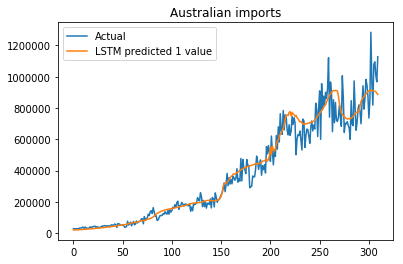

In [29]:
y_imports_lstm_1 = session_lstm(1000, X_imports_batch_1, y_imports_batch_1, X_imports_test_data_1)
y_imports_lstm_predict_1 = data_transform(y_imports_lstm_1,scaler_imports, 1)

plt.plot(pd.Series(np.ravel(y_imports_test_data_1[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_lstm_predict_1[0:])), label= "LSTM predicted 1 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()

0 	MSE 0.108489886
100 	MSE 0.017952142
200 	MSE 0.009521016
300 	MSE 0.006920954
400 	MSE 0.007060583
500 	MSE 0.005652701
600 	MSE 0.005256382
700 	MSE 0.004663101
800 	MSE 0.0042229933
900 	MSE 0.0036394603
1000 	MSE 0.003369472
1100 	MSE 0.0033628368
1200 	MSE 0.003058556
1300 	MSE 0.0029048629
1400 	MSE 0.0029210956
1500 	MSE 0.0028881722
1600 	MSE 0.0031290571
1700 	MSE 0.0026738532
1800 	MSE 0.0028396838
1900 	MSE 0.002544286


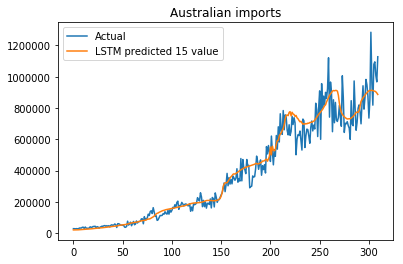

In [30]:
y_imports_lstm_30 = session_lstm(2000, X_imports_batch_30, y_imports_batch_30, X_imports_test_data_30)
y_imports_lstm_predict_30 = data_transform(y_imports_lstm_30,scaler_imports, 15)

plt.plot(pd.Series(np.ravel(y_imports_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_lstm_predict_30[0:])), label= "LSTM predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()

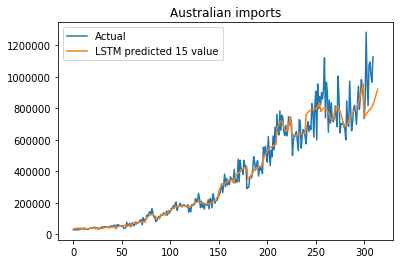

In [33]:
y_imports_lstm_predict_30 = data_transform(y_imports_lstm_30,scaler_imports, 15)
plt.plot(pd.Series(np.ravel(y_imports_test_data_30[0:])),label="Actual")
plt.plot(pd.Series(np.ravel(y_imports_lstm_predict_30[0:])), label= "LSTM predicted 15 value")
plt.legend(loc = "upper left")
plt.title('Australian imports')
plt.show()